# CS 316 : Introduction to Deep Learning - Fall 2024
## Lab 11 : Convolutional Neural Networks and ResNet
### Dr. Abdul Samad

# Instructions

1. Make a copy of this notebook on google colab at start of the lab.

2. Please rename your notebook as *Lab_11_aa12345.ipynb* before starting the lab. Notebooks which do not follow appropriate naming convention will not be graded.

3. You have to submit this lab during the lab timings. You are allowed to submit till 11:59 PM on the day of your lab with a 30% penalty. No submissions will be accepted afterwards.

4. Use of AI is strictly prohibited. Anyone caught using Any AI tool during lab or while grading will be immediately reported to OCVS without any further discussion.

5. At the end of the lab, download the notebook (ipynb extension file) and upload it on canvas as a file. Submitting link to notebook or any other file will not be accepted.

6. Each task has points assigned to it. Total Lab is of 100 points.

7. Use of for loops is strictly prohibited.

8. For every theoretical question, there is a separate cell given at the end. You have to write your answer there.

9. If you have any questions, please feel free to reach out to the course instructor or RA.

## Task Overview


In this lab we will again work on CNNs. This Lab is going to be a little long. Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Let's start with importing Libraries first

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# **Convolution for CIFAR10**

This notebook builds a proper network for 2D convolution.  It works with the CIFAR10 dataset , which was the original classic dataset for classifying images.  The network will take a 32x32x3 image and classify it into one of 10 classes representing an object.



In [2]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches

# (It may complain that some files are missing because the files seem to have been
# reorganized on the underlying website, but it still seems to work). If everything is working
# properly, then the whole notebook should run to the end without further problems
# even before you make changes.
batch_size_train = 20
batch_size_test = 16
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('/cifar10_data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.CenterCrop(28),
                                 torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('/cifar10_data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.CenterCrop(28),
                                 torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 170M/170M [00:04<00:00, 35.1MB/s]


Extracting /cifar10_data/cifar-10-python.tar.gz to /cifar10_data/
Files already downloaded and verified


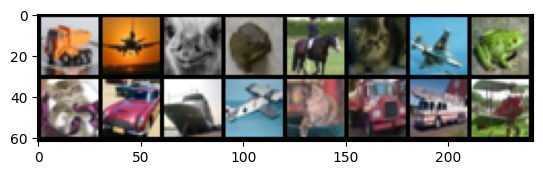

In [3]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

def imshow(img):    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(example_data))

Before we go in depth on declaring the network, Let's look at another way of writing network architecture. Look at the code block given below.

This is implementation of the below given network:
1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
2. A max pooling operation over a 2x2 area
3. A Relu
4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
5. A Relu
5. A 2D Dropout layer
6. A flattening operation
7. A fully connected layer
8. A softmax function.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        # 1. A valid convolution with kernel size 5, 1 input channel, and 10 output channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)

        # 4. A valid convolution with kernel size 5, 10 input channels, and 20 output channels
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)

        # 5. A 2D Dropout layer
        self.drop = nn.Dropout2d()

        # 9. A fully connected layer mapping from whatever dimensions to 50
        self.fc1 = nn.Linear(20 * 4 * 4, 50)

    def forward(self, x):
        # 1. Convolution layer 1
        x = self.conv1(x)

        # 2. A max pooling operation over a 2x2 area
        x = F.max_pool2d(x, 2)

        # 3. A ReLU
        x = F.relu(x)

        # 4. Convolution layer 2
        x = self.conv2(x)

        # 7. A ReLU
        x = F.relu(x)

        # 5. Apply Dropout
        x = self.drop(x)

        # 8. Flatten the output
        x = x.flatten(1)

        # 9. Fully connected layer mapping to 50
        x = self.fc1(x)

        # 12. Apply softmax to the output
        x = F.log_softmax(x, dim=1)

        return x


As you can see, this network actually declares the layers first in init function and then calls them in forward function. Here, you will also see passing of data using x. Both methods (one you studied in last lab and this one) are completely valid forimplementation. That method has some limitations though. Let's start working on network architectures again now.

# Q1: TODO [35 Points]

We will again build Alexnet Architecture in this lab. Only difference is it is this time on cifar10 dataset instead. cifar10 has images of size 32x32x3. However, if you go to dataloader, you will see that this has been cropped. So you will take input size as 28x28x3. Here is the architecture:
1. A convolution with kernel size 11, 3 input channel, 64 output channels and padding 1
3. A Relu
2. A max pooling operation with kernel size 3 and stride 1
4. A valid convolution with kernel size 5, padding 1 and 128 output channels
3. A Relu
2. A max pooling operation with kernel size 3 and stride 1
4. A valid convolution with kernel size 3, padding 1 and 256 output channels
3. A Relu
4. A valid convolution with kernel size 3, padding 1 and 128 output channels
3. A Relu
4. A valid convolution with kernel size 3, padding 1 and 128 output channels
3. A Relu
2. A max pooling operation with kernel size 3 and stride 1
8. A flattening operation
5. A 2D Dropout layer
9. A fully connected layer mapping from (whatever dimensions we are at-- find out using formulas studied in class. You will also need to submit picture of calculation. Without that this question will not be graded) to 4096
10. A ReLU
5. A 2D Dropout layer
11. A fully connected layer mapping from 4096 to 4096 dimensions
10. A ReLU
11. A fully connected layer mapping from 4096 to 10 dimensions
12. A Log softmax function.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #TODO
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=1, padding=1)

        # self.pool1 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1)

        # self.pool2 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        # self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)

        self.drop1 = nn.Dropout2d()

        self.fc1 = nn.Linear(128 * 12 * 12, 4096)

        self.drop2 = nn.Dropout2d()

        self.fc2 = nn.Linear(4096, 4096)

        self.fc3 = nn.Linear(4096, 10)
        #END TODO
    def forward(self, x):
        #TODO

        x = self.conv1(x)                                   # 1
        x = F.relu(x)                                    # 2
        x = F.max_pool2d(x, kernel_size=3, stride=1)        # 3
        x = self.conv2(x)                                   # 4
        x = F.relu(x)                                 # 5
        x = F.max_pool2d(x, kernel_size=3, stride=1)    # 6
        x = self.conv3(x)                                   # 7
        x = F.relu(x)                                 # 8
        x = self.conv4(x)                                   # 9
        x = F.relu(x)                                 # 10
        x = self.conv5(x)                                   # 11
        x = F.relu(x)                                 # 12
        x = F.max_pool2d(x, kernel_size=3, stride=1)    # 13
        x = x.flatten(1)                                # 14
        x = self.drop2(x)                                # 15
        x = self.fc1(x)                                   # 16
        x = F.relu(x)                                 # 17
        x = self.drop2(x)                                # 18
        x = self.fc2(x)                                   # 19
        x = F.relu(x)                                 # 20
        x = self.fc3(x)                                   # 21
        x = F.log_softmax(x, dim=1)                    # 22
        #END TODO
        return x


In [6]:
# Initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [7]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    if torch.cuda.is_available():
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [8]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
      if torch.cuda.is_available():
          data, target = data.cuda(), target.cuda()
      data, target = Variable(data, volatile=True), Variable(target)
      output = model(data)
      test_loss += F.cross_entropy(output, target, size_average=False).item()# sum up batch loss
      pred = output.data.max(1, keepdim=True)[1]# get the index of the max log-probability
      correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
  test_loss /= len(test_loader.dataset)
  correct=float(correct.to(torch.device('cpu')).numpy())
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [9]:
model = Net()
print(model)
if torch.cuda.is_available():
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop1): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=18432, out_features=4096, bias=True)
  (drop2): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)


In [10]:
# Train for three epochs
n_epochs = 3
for epoch in range(1,n_epochs+1):
  train(epoch)
  test()

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/50000]	Loss: 2.302180
Train Epoch: 1 [200/50000]	Loss: 2.309025
Train Epoch: 1 [400/50000]	Loss: 2.371207
Train Epoch: 1 [600/50000]	Loss: 2.329133
Train Epoch: 1 [800/50000]	Loss: 2.300487
Train Epoch: 1 [1000/50000]	Loss: 2.290645
Train Epoch: 1 [1200/50000]	Loss: 2.290099
Train Epoch: 1 [1400/50000]	Loss: 2.158215
Train Epoch: 1 [1600/50000]	Loss: 2.309336
Train Epoch: 1 [1800/50000]	Loss: 2.182426
Train Epoch: 1 [2000/50000]	Loss: 2.289562
Train Epoch: 1 [2200/50000]	Loss: 2.158749
Train Epoch: 1 [2400/50000]	Loss: 2.127350
Train Epoch: 1 [2600/50000]	Loss: 2.140686
Train Epoch: 1 [2800/50000]	Loss: 1.835191
Train Epoch: 1 [3000/50000]	Loss: 2.016897
Train Epoch: 1 [3200/50000]	Loss: 1.982921
Train Epoch: 1 [3400/50000]	Loss: 1.952608
Train Epoch: 1 [3600/50000]	Loss: 2.039061
Train Epoch: 1 [3800/50000]	Loss: 2.193171
Train Epoch: 1 [4000/50000]	Loss: 2.285091
Train Epoch: 1 [4200/50000]	Loss: 2.054374
Train Epoch: 1 [4400/50000]	Loss: 2.200417
Train Epoch: 1 [46

<ipython-input-8-0b1ccd3c1330>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.5343, Accuracy: 4381.0/10000 (44%)

Train Epoch: 2 [0/50000]	Loss: 1.765718
Train Epoch: 2 [200/50000]	Loss: 1.432773
Train Epoch: 2 [400/50000]	Loss: 1.279602
Train Epoch: 2 [600/50000]	Loss: 1.418874
Train Epoch: 2 [800/50000]	Loss: 1.685287
Train Epoch: 2 [1000/50000]	Loss: 1.502149
Train Epoch: 2 [1200/50000]	Loss: 1.423574
Train Epoch: 2 [1400/50000]	Loss: 1.379793
Train Epoch: 2 [1600/50000]	Loss: 1.801830
Train Epoch: 2 [1800/50000]	Loss: 1.204981
Train Epoch: 2 [2000/50000]	Loss: 1.249524
Train Epoch: 2 [2200/50000]	Loss: 1.177025
Train Epoch: 2 [2400/50000]	Loss: 1.453322
Train Epoch: 2 [2600/50000]	Loss: 1.312431
Train Epoch: 2 [2800/50000]	Loss: 1.399197
Train Epoch: 2 [3000/50000]	Loss: 1.585746
Train Epoch: 2 [3200/50000]	Loss: 1.467619
Train Epoch: 2 [3400/50000]	Loss: 1.781183
Train Epoch: 2 [3600/50000]	Loss: 1.348298
Train Epoch: 2 [3800/50000]	Loss: 1.335227
Train Epoch: 2 [4000/50000]	Loss: 1.343191
Train Epoch: 2 [4200/50000]	Loss: 1.343863
T

<ipython-input-11-3adadbd67f9a>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  example_data, example_target = Variable(example_data, volatile=True), Variable(example_target)


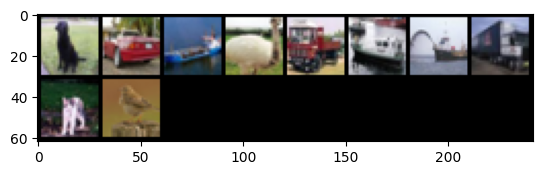

Truck Airplane  Bird  Frog Horse   Cat Airplane  Frog   Cat   Car


In [11]:
# Run network on data we got before and show predictions
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)
if torch.cuda.is_available():
  example_data, example_target = example_data.cuda(), example_target.cuda()
example_data, example_target = Variable(example_data, volatile=True), Variable(example_target)
output = model(example_data)

def imshow(img):    # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(example_data[:10,:]))
# print labels
print(' '.join('%5s' % classes[example_targets[j]] for j in range(10)))

# Q2: TODO [30 Points]
After being done with AlexNet, Let's do the same thing on VGGNet.

if you don't know what VGG is, don't worry. This lab doesn't require the background of it. Its just an architecture and we are implementing it.

Here is VGGNet Architecture:

1. A convolution with kernel size 3, 3 input channels, 64 output channels and padding 1
3. A Relu
4. A valid convolution with kernel size 3, padding 1 and 64 output channels
3. A Relu
2. A max pooling operation with kernel size 2 and stride 2
4. A valid convolution with kernel size 3, padding 1 and 128 output channels
3. A Relu
4. A valid convolution with kernel size 3, padding 1 and 128 4output channels
3. A Relu
2. A max pooling operation with kernel size 2 and stride 2
4. A valid convolution with kernel size 3, padding 1 and 256 output channels
3. A Relu
4. A valid convolution with kernel size 3, padding 1 and 256 output channels
3. A Relu
4. A valid convolution with kernel size 3, padding 1 and 256 output channels
3. A Relu
2. A max pooling operation with kernel size 2 and stride 1
4. A valid convolution with kernel size 3, padding 1 and 512 output channels
3. A Relu
4. A valid convolution with kernel size 3, padding 1 and 512 4output channels
3. A Relu
4. A valid convolution with kernel size 3, padding 1 and 512 4output channels
3. A Relu
2. A max pooling operation with kernel size 2 and stride 1
4. A valid convolution with kernel size 3, padding 1 and 512 output channels
3. A Relu
4. A valid convolution with kernel size 3, padding 1 and 512 output channels
3. A Relu
4. A valid convolution with kernel size 3, padding 1 and 512 output channels
3. A Relu
2. A max pooling operation with kernel size 2 and stride 1
8. A flattening operation
9. A fully connected layer mapping from (whatever dimensions we are at-- find out using formulas studied in class. You will also need to submit picture of calculation. Without that this question will not be graded) to 4096
10. A ReLU
12. A Dropout Layer
11. A fully connected layer mapping from 4096 to 4096 dimensions
10. A ReLU
12. A Dropout Layer
11. A fully connected layer mapping from 4096 to 10 dimensions
12. A Log softmax function.


            


In [12]:
class Net(nn.Module):
    def __init__(self, num=10):
        super(Net, self).__init__()
        #TODO
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(4*4*512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num)

        self.drop1 = nn.Dropout2d()
        self.drop2 = nn.Dropout2d()
        #END TODO
    def forward(self, x):
        #TODO

        x = self.conv1(x)                                   # 1
        x = F.relu(x)                                    # 2
        x = self.conv2(x)                                   # 3
        x = F.relu(x)                                    # 4
        x = F.max_pool2d(x, kernel_size=2, stride=2)        # 5
        x = self.conv3(x)                                   # 6
        x = F.relu(x)                                    # 7
        x = self.conv4(x)                                   # 8
        x = F.relu(x)                                    # 9
        x = F.max_pool2d(x, kernel_size=2, stride=2)        # 10
        x = self.conv5(x)                                   # 11
        x = F.relu(x)                                    # 12
        x = self.conv6(x)                                   # 13
        x = F.relu(x)                                    # 14
        x = self.conv7(x)                                   # 15
        x = F.relu(x)                                    # 16
        x = F.max_pool2d(x, kernel_size=2, stride=1)        # 17
        x = self.conv8(x)                                   # 18
        x = F.relu(x)                                    # 19
        x = self.conv9(x)                                   # 20
        x = F.relu(x)                                    # 21
        x = self.conv10(x)                                  # 22
        x = F.relu(x)                                    # 23
        x = F.max_pool2d(x, kernel_size=2, stride=1)        # 24
        x = self.conv11(x)                                  # 25
        x = F.relu(x)                                    # 26
        x = self.conv12(x)                                  # 27
        x = F.relu(x)                                    # 28
        x = self.conv13(x)                                  # 29
        x = F.relu(x)                                    # 30
        x = F.max_pool2d(x, kernel_size=2, stride=1)        # 31
        x = x.flatten(1)                                # 32
        x = self.fc1(x)                                   # 33
        x = F.relu(x)                                    # 34
        x = self.drop1(x)                                 # 35
        x = self.fc2(x)                                   # 36
        x = F.relu(x)                                    # 37
        x = self.drop2(x)                                 # 38
        x = self.fc3(x)                                   # 39
        x = F.log_softmax(x, dim=1)                    # 40
        #END TODO
        return x

In [13]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    if torch.cuda.is_available():
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [14]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
      if torch.cuda.is_available():
          data, target = data.cuda(), target.cuda()
      data, target = Variable(data, volatile=True), Variable(target)
      output = model(data)
      test_loss += F.cross_entropy(output, target, size_average=False).item()# sum up batch loss
      pred = output.data.max(1, keepdim=True)[1]# get the index of the max log-probability
      correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
  test_loss /= len(test_loader.dataset)
  correct=float(correct.to(torch.device('cpu')).numpy())
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [15]:
model = Net()
print(model)
if torch.cuda.is_available():
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3, 3), s

In [16]:
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/50000]	Loss: 2.300760
Train Epoch: 1 [200/50000]	Loss: 2.300475
Train Epoch: 1 [400/50000]	Loss: 2.303923
Train Epoch: 1 [600/50000]	Loss: 2.306436
Train Epoch: 1 [800/50000]	Loss: 2.308926
Train Epoch: 1 [1000/50000]	Loss: 2.299180
Train Epoch: 1 [1200/50000]	Loss: 2.303665
Train Epoch: 1 [1400/50000]	Loss: 2.301714
Train Epoch: 1 [1600/50000]	Loss: 2.299780
Train Epoch: 1 [1800/50000]	Loss: 2.299190
Train Epoch: 1 [2000/50000]	Loss: 2.306396
Train Epoch: 1 [2200/50000]	Loss: 2.307463
Train Epoch: 1 [2400/50000]	Loss: 2.303869
Train Epoch: 1 [2600/50000]	Loss: 2.302402
Train Epoch: 1 [2800/50000]	Loss: 2.304625
Train Epoch: 1 [3000/50000]	Loss: 2.303334
Train Epoch: 1 [3200/50000]	Loss: 2.301796
Train Epoch: 1 [3400/50000]	Loss: 2.304515
Train Epoch: 1 [3600/50000]	Loss: 2.304254
Train Epoch: 1 [3800/50000]	Loss: 2.303032
Train Epoch: 1 [4000/50000]	Loss: 2.303515
Train Epoch: 1 [4200/50000]	Loss: 2.304121
Train Epoch: 1 [4400/50000]	Loss: 2.305342
Train Epoch: 1 [46

<ipython-input-14-0b1ccd3c1330>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Avg. loss: 2.3028, Accuracy: 1000.0/10000 (10%)

Train Epoch: 2 [0/50000]	Loss: 2.305796
Train Epoch: 2 [200/50000]	Loss: 2.300662
Train Epoch: 2 [400/50000]	Loss: 2.314102
Train Epoch: 2 [600/50000]	Loss: 2.307076
Train Epoch: 2 [800/50000]	Loss: 2.298326
Train Epoch: 2 [1000/50000]	Loss: 2.303477
Train Epoch: 2 [1200/50000]	Loss: 2.295156
Train Epoch: 2 [1400/50000]	Loss: 2.301655
Train Epoch: 2 [1600/50000]	Loss: 2.302938
Train Epoch: 2 [1800/50000]	Loss: 2.306079
Train Epoch: 2 [2000/50000]	Loss: 2.299943
Train Epoch: 2 [2200/50000]	Loss: 2.298223
Train Epoch: 2 [2400/50000]	Loss: 2.303936
Train Epoch: 2 [2600/50000]	Loss: 2.301372
Train Epoch: 2 [2800/50000]	Loss: 2.294582
Train Epoch: 2 [3000/50000]	Loss: 2.301991
Train Epoch: 2 [3200/50000]	Loss: 2.310151
Train Epoch: 2 [3400/50000]	Loss: 2.303352
Train Epoch: 2 [3600/50000]	Loss: 2.295336
Train Epoch: 2 [3800/50000]	Loss: 2.296387
Train Epoch: 2 [4000/50000]	Loss: 2.298602
Train Epoch: 2 [4200/50000]	Loss: 2.285804
T

<ipython-input-17-3adadbd67f9a>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  example_data, example_target = Variable(example_data, volatile=True), Variable(example_target)


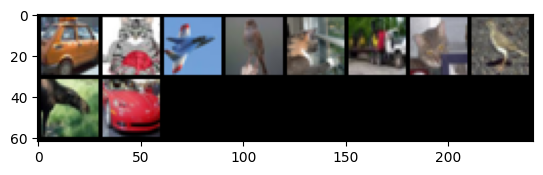

Truck Airplane  Bird  Frog Horse   Cat Airplane  Frog   Cat   Car


In [17]:
# Run network on data we got before and show predictions
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)
if torch.cuda.is_available():
  example_data, example_target = example_data.cuda(), example_target.cuda()
example_data, example_target = Variable(example_data, volatile=True), Variable(example_target)
output = model(example_data)

def imshow(img):    # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(example_data[:10,:]))
# print labels
print(' '.join('%5s' % classes[example_targets[j]] for j in range(10)))

# TODO

This doesn't give a good accuracy though right? We applied the same amount of layers (no of conv nets and fully connected neurons in this and the vgg is same. no of neurons in fully connected is also same). This aprt isn't graded but can you try it at home and find out what changed will increase the accuracy of this network? Then can be abount anything including learning rate, epochs data etc.

# Q3: TODO [30 Points]
After being done with VGGNet, Let's work on ResNet.

if you don't know what ResNet is, don't worry. This lab doesn't require the background of it. Its just an architecture and we are implementing it. Here is ResNet architecture (output from first image goes into seocnd image i.e. both are connected):

Resnet Blocks are similar to any other network except they carry some previous stored info to next layer or in other words some residue to next layer. In the above given image where you are seeing add function, there you will see that output is coming from the most recent layer and also from some previous layer. We will study in depth about it in class as well. Right now, let's try implementing it. Some portion of code is already given. You just need to fill in missing pieces by looking at the image above and formulas which you studied during your classes.

This code actually has a conv_block function which can make layer blocks based on input. This function is being called in Class Net and as you can see first conv1 block is made by calling it. You can then see that block is connected in Forward Function. You can compare it with the image as well.

Now to make a few things easy, each pooling block is of same size and hence size has been made fixed in conv block. for convolutional layers, kernel size is fixed at 3 and padding at 1. Only major change gence is of input and output channels so here is the info for that.


    conv layer 1: in_channels=3, out_channels=64
    conv layer 2: in_channels=64, out_channels=128
    conv layer 3: in_channels=128, out_channels=128
    conv layer 4: in_channels=128, out_channels=128
    conv layer 5: in_channels=128, out_channels=256
    conv layer 6: in_channels=256, out_channels=512
    conv layer 7: in_channels=512, out_channels=512
    conv layer 8: in_channels=512, out_channels=512


In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        # TODO
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        # END TODO
        self.classifier = nn.Sequential(nn.MaxPool2d(2),
                                        nn.Flatten(),
                                        nn.Linear(512, 10))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        # TODO

        out = self.conv3(out)
        out = self.conv4(out)

        out = self.res2(out) + out

        out = self.classifier(out)

        #END TODO
        return out

In [19]:
model = Net()
print(model)
if torch.cuda.is_available():
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)


In [20]:
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Train Epoch: 1 [0/50000]	Loss: 3.731579
Train Epoch: 1 [200/50000]	Loss: 3.845282
Train Epoch: 1 [400/50000]	Loss: 3.068728
Train Epoch: 1 [600/50000]	Loss: 2.558751
Train Epoch: 1 [800/50000]	Loss: 2.364724
Train Epoch: 1 [1000/50000]	Loss: 1.754061
Train Epoch: 1 [1200/50000]	Loss: 1.766104
Train Epoch: 1 [1400/50000]	Loss: 1.960237
Train Epoch: 1 [1600/50000]	Loss: 2.526944
Train Epoch: 1 [1800/50000]	Loss: 2.034320
Train Epoch: 1 [2000/50000]	Loss: 1.501211
Train Epoch: 1 [2200/50000]	Loss: 1.849944
Train Epoch: 1 [2400/50000]	Loss: 2.089311
Train Epoch: 1 [2600/50000]	Loss: 1.663869
Train Epoch: 1 [2800/50000]	Loss: 1.838159
Train Epoch: 1 [3000/50000]	Loss: 2.078507
Train Epoch: 1 [3200/50000]	Loss: 2.168740
Train Epoch: 1 [3400/50000]	Loss: 1.856550
Train Epoch: 1 [3600/50000]	Loss: 1.200735
Train Epoch: 1 [3800/50000]	Loss: 1.700612
Train Epoch: 1 [4000/50000]	Loss: 1.480917
Train Epoch: 1 [4200/50000]	Loss: 1.696421
Train Epoch: 1 [4400/50000]	Loss: 2.034388
Train Epoch: 1 [46

<ipython-input-14-0b1ccd3c1330>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Avg. loss: 0.8981, Accuracy: 6825.0/10000 (68%)

Train Epoch: 2 [0/50000]	Loss: 0.654532
Train Epoch: 2 [200/50000]	Loss: 1.029810
Train Epoch: 2 [400/50000]	Loss: 0.870169
Train Epoch: 2 [600/50000]	Loss: 0.665053
Train Epoch: 2 [800/50000]	Loss: 0.593758
Train Epoch: 2 [1000/50000]	Loss: 1.296146
Train Epoch: 2 [1200/50000]	Loss: 0.548591
Train Epoch: 2 [1400/50000]	Loss: 0.929894
Train Epoch: 2 [1600/50000]	Loss: 1.216652
Train Epoch: 2 [1800/50000]	Loss: 1.067426
Train Epoch: 2 [2000/50000]	Loss: 0.684273
Train Epoch: 2 [2200/50000]	Loss: 0.957926
Train Epoch: 2 [2400/50000]	Loss: 0.771030
Train Epoch: 2 [2600/50000]	Loss: 0.537830
Train Epoch: 2 [2800/50000]	Loss: 1.144055
Train Epoch: 2 [3000/50000]	Loss: 0.567103
Train Epoch: 2 [3200/50000]	Loss: 0.974064
Train Epoch: 2 [3400/50000]	Loss: 0.506676
Train Epoch: 2 [3600/50000]	Loss: 0.779136
Train Epoch: 2 [3800/50000]	Loss: 0.822205
Train Epoch: 2 [4000/50000]	Loss: 0.768403
Train Epoch: 2 [4200/50000]	Loss: 1.080364
T

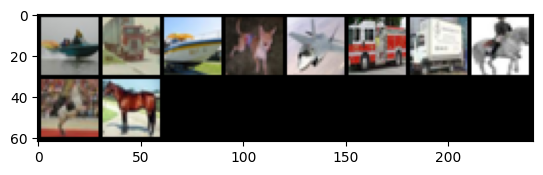

Truck Airplane  Bird  Frog Horse   Cat Airplane  Frog   Cat   Car


In [21]:
# Run network on data we got before and show predictions
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)
if torch.cuda.is_available():
  example_data, example_target = example_data.cuda(), example_target.cuda()
output = model(example_data)

def imshow(img):    # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(example_data[:10,:]))
# print labels
print(' '.join('%5s' % classes[example_targets[j]] for j in range(10)))

## Good Job.